# **Recap of [Lesson 5](https://colab.research.google.com/drive/1Zf24gIVMNNj9j-gtXFl8p0orI9ttySDn#forceEdit=true&sandboxMode=true) 👩‍💻🚀**

1. Explored 3 dlt write dispositions:
  * append;
  * replace;
  * merge.
2. Learned how to update and depuplicate data
3. Created incremental pipeline


# **How dlt works** 🧠🧠

**Here, you will learn:**
- Three main steps:
  - Extract;
  - Normalize;
  - Load.  
- Some default behaviour.
- About file formats.

## **Introduction**

The main building block of dlt is the **pipeline**, which orchestrates the loading of data from your source into your destination in three discrete steps when you call its **run** method.

So, let's take a step back and walk through the internal steps of `pipeline.run()`, identifying methods to optimize each one.

# **Understing `pipeline.run()`**
 The `pipeline.run()` method executes the entire pipeline, encompassing the [`extract`](#scrollTo=4C0U1dnwZxAB), [`normalize`](#scrollTo=bCeUqaW_cRSh), and [`load`](#scrollTo=Rn6cUc0OcWsk) stages.

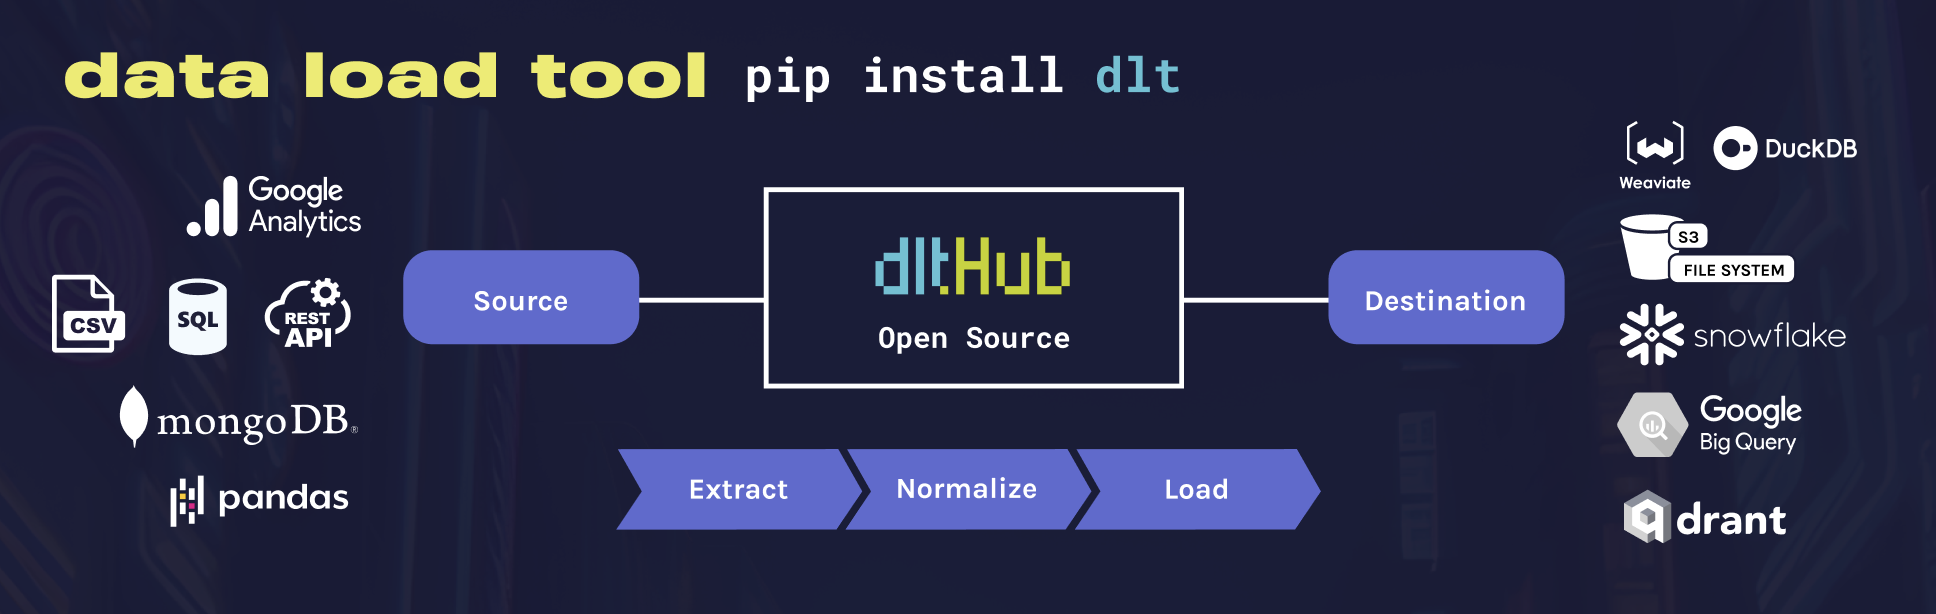

Consider this intentionally short example:

In [1]:
%%capture
!pip install -U dlt

In [2]:
import dlt

pipeline = dlt.pipeline(
    pipeline_name="my_pipeline",
    destination="duckdb",
    progress="log"
)

load_info = pipeline.run(
    [
        {"id": 1},
        {"id": 2},
        {"id": 3, "nested": [{"id": 1}, {"id": 2}]},
    ],
    table_name="items",
)
print(load_info)

---------------------------------- Extract my ----------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 250.09 MB (8.60%) | CPU usage: 0.00%

---------------------------------- Extract my ----------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
items: 1  | Time: 0.00s | Rate: 99864.38/s
Memory usage: 250.09 MB (8.60%) | CPU usage: 0.00%

---------------------------------- Extract my ----------------------------------
Resources: 1/1 (100.0%) | Time: 0.01s | Rate: 67.05/s
items: 3  | Time: 0.01s | Rate: 242.89/s
Memory usage: 250.09 MB (8.60%) | CPU usage: 0.00%

---------------------------------- Extract my ----------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 250.09 MB (8.60%) | CPU usage: 0.00%

---------------------------------- Extract my ----------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
_dlt_pipeline_state: 1  | Time: 0.00s | Rate:

This is what happens when the `run` method is executed:

1. **Extract** - Fully extracts the data from your source to your hard drive. In the example above, an implicit source with one resource with 3 items is created and extracted.
2. **Normalize** - Inspects and normalizes your data and computes a schema compatible with your destination. For the example above, the normalizer will detect one column `id` of type `int` in one table named `items`, it will furthermore detect a nested list in table items and unnest it into a child table named `items__nested`.
3. **Load** - Runs schema migrations if necessary on your destination and loads your data into the destination. For the example above, a new dataset on a local duckdb database is created that contains the two tables discovered in the previous steps.


## **Display the loading progress**
Notice how we use `progress="log"` here.

The `progress="log"` argument in the `dlt.pipeline` configuration enables detailed logging of the pipeline’s progress during execution. These logs provide visibility into the pipeline’s operations, showing how data flows through the **Extract**, **Normalize**, and **Load** phases. The logs include real-time metrics such as resource or file counts, time elapsed, processing rates, memory usage, and CPU utilization.


dlt supports 4 progress monitors out of the box:

* `enlighten` - a status bar with progress bars that also allows for logging.
* `tqdm` - the most popular Python progress bar lib, proven to work in Notebooks.
* `alive_progress` - with the most fancy animations.
* `log` - dumps the progress information to log, console, or text stream. the most useful on production optionally adds memory and CPU usage stats.

For more information read the [official documentation](https://dlthub.com/docs/general-usage/pipeline#display-the-loading-progress).

## **Extract**

Extract can be run individually with the `extract` command on the pipeline:

```python
pipeline.extract(data)
```


### **What happens at the extraction stage?**

When the `pipeline.run()` method is executed, it first performs the `extract` stage, during which the following occurs:

1. Data is fetched and stored in an in-memory buffer.
2. When the buffer reaches its capacity, the data inside it is written to an intermediary file, and the buffer is cleared for the next set of data items.
3. If a size is specified for intermediary files and an the intermediary file in question reaches this size, a new intermediary file is opened for further data.

```
               API Data
                  | (extract)
                Buffer
(resources) /  | ... |   \
     extracted data in local storage

```

The **number** of intermediate **files** depends on the number of **resources** and whether **file rotation** is enabled.

### **Default behaviour at the extraction stage**

- The in-memory buffer is set to `5000` items.
- By default, **intermediary files are not rotated**. If you do not explicitly set a size for an intermediary file with `file_max_items=100000`, `dlt` will create a **single file** for a resource, regardless of the number of records it contains, even if it reaches millions.
- By default, intermediary files at the extract stage use a custom version of the JSONL format.

## **Normalize**

Normalize can be run individually with the `normalize` command on the pipeline. Normalize is dependent on having a completed extract phase and will not do anything if there is no extracted data.

```py
pipeline.normalize()
```

### **What happens at the normalization stage?**

In the `normalize` stage, `dlt` first transforms the structure of the input data. This transformed data is then converted into a relational structure that can be easily loaded into the destination. To be detailed, here's what happens during this stage:

1. Intermediary files are sent from the `extract` stage to the `normalize` stage.
3. During normalization step it processes one intermediate file at a time within its own in-memory buffer.
4. When the buffer reaches its capacity, the normalized data inside it is written to an intermediary file, and the buffer is cleared for the next set of data items.
4. If a size is specified for intermediary files in the normalize stage and the intermediary file in question reaches this size, a new intermediary file is opened.

```
       (extract)
API Data --> extracted files in local storage
                /     |      \     (normalize)
          one file  ...  one file
          /  |  \          / | \   
      normalized files   normalized files        

```


The **number** of intermediate **files** depends on the number of **resources** and whether **file rotation** is enabled.

### **Default behaviour at the normalization stage**

- The in-memory buffer is set to `5000`, just like at the extraction stage.
- By default, **intermediary files are not rotated** as well. If you do not explicitly set a size for an intermediary file with `file_max_items=100000`, dlt will create a **single file** for a resource, regardless of the number of records it contains, even if it reaches millions.

## **Load**

Load can be run individually with the `load` command on the pipeline. Load is dependent on having a completed normalize phase and will not do anything if there is no normalized data.

```py
pipeline.load()
```

### **What happens at the loading stage?**

The `load` stage is responsible for taking the normalized data and loading it into your chosen destination:

1. All intermediary files from a single source are combined into a single load package.
2. All load packages are then loaded into the destination.


```
    (extract)             (normalize)
API Data --> extracted files --> normalized files     
                                  /  |  ... |  \   (load)
                    one normalized file ... one file
                                 \   |  ... |   /
                                    destination
                                           
```

### **Default behaviour at the loading stage**

- Loading happens in `20` threads, each loading a single file.

## **Intermediary file formats**

Intermediary files at the extract stage use a custom version of the JSONL format, while the loader files - files  created at the normalize stage - can take 4 different formats.

### **JSONL**

**Definition**: JSON Delimited is a file format that stores several JSON documents in one file. The JSON documents are separated by a new line.

**Compression:** enabled by default.

**Data type handling:**

- `datetime` and `date` are stored as ISO strings;
- `decimal` is stored as a text representation of a decimal number;
- `binary` is stored as a base64 encoded string;
- `HexBytes` is stored as a hex encoded string;
- `complex` is serialized as a string.

**By default used by:**

- Bigquery
- Snowflake
- Filesystem

**Configuration**:

- Directly in the `pipeline.run()`:

  ```py
  info = pipeline.run(some_source(), loader_file_format="jsonl")
  ```

- In `config.toml` or `secrets.toml`:

  ```py
  [normalize]
  loader_file_format="jsonl"
  ```

- Via environment variables:

  ```py
  export NORMALIZE__LOADER_FILE_FORMAT="jsonl"
  ```

- Specify directly in the resource decorator:

  ```py
  @dlt.resource(file_format="jsonl")
  def generate_rows():
    ...
  ```

### **Parquet**

**Definition**: Apache Parquet is a free and open-source column-oriented data storage format in the Apache Hadoop ecosystem.

**Prerequisite:** To use this format, you need a pyarrow package. You can get this package as a dlt extra as well:

```py
pip install "dlt[parquet]"

```

**Default version**: 2.4, which coerces timestamps to microseconds and silently truncates nanoseconds for better compatibility with databases and pandas.

**Supported by:**

- Bigquery
- DuckDB
- Snowflake
- Filesystem
- Athena
- Databricks
- Synapse

**Configuration**:

- Directly in the `pipeline.run()`:

  ```py
  info = pipeline.run(some_source(), loader_file_format="parquet")
  ```

- In `config.toml` or `secrets.toml`:

  ```py
  [normalize]
  loader_file_format="parquet"
  ```

- Via environment variables:

  ```py
  export NORMALIZE__LOADER_FILE_FORMAT="parquet"
  ```

- Specify directly in the resource decorator:

  ```py
  @dlt.resource(file_format="parquet")
  def generate_rows():
    ...
  ```


**Destination AutoConfig**:

`dlt` automatically configures the Parquet writer based on the destination's capabilities:

- Selects the appropriate decimal type and sets the correct precision and scale for accurate numeric data storage, including handling very small units like Wei.

- Adjusts the timestamp resolution (seconds, microseconds, or nanoseconds) to match what the destination supports


**Writer settings:**

`dlt` uses the pyarrow Parquet writer for file creation. You can adjust the writer's behavior with the following options:

- `flavor` adjusts schema and compatibility settings for different target systems. Defaults to None (pyarrow default).
- `version` selects Parquet logical types based on the Parquet format version. Defaults to "2.6".
- `data_page_size` sets the target size for data pages within a column chunk (in bytes). Defaults to None.
- `timestamp_timezone` specifies the timezone; defaults to UTC.
- `coerce_timestamps` sets the timestamp resolution (s, ms, us, ns).
- `allow_truncated_timestamps` raises an error if precision is lost on truncated timestamps.

  **Example configurations:**

  - In `configs.toml` or `secrets.toml`:
    ```py
    [normalize.data_writer]
    # the default values
    flavor="spark"
    version="2.4"
    data_page_size=1048576
    timestamp_timezone="Europe/Berlin"
    ```

  - Via environment variables:
    ```py
    export  NORMALIZE__DATA_WRITER__FLAVOR="spark"
    ```


**Timestamps and timezones**

`dlt` adds UTC adjustments to all timestamps, creating timezone-aware timestamp columns in destinations (except DuckDB).

**Disable timezone/UTC adjustments:**

- Set `flavor` to spark to use the deprecated `int96` timestamp type without logical adjustments.

- Set `timestamp_timezone` to an empty string (`DATA_WRITER__TIMESTAMP_TIMEZONE=""`) to generate logical timestamps without UTC adjustment.

By default, pyarrow converts timezone-aware DateTime objects to UTC and stores them in Parquet without timezone information.


### **CSV**

**Supported by:**

- PostgreSQL
- Filesystem
- Snowflake

**Configuration**:

- Directly in the `pipeline.run()`:

  ```py
  info = pipeline.run(some_source(), loader_file_format="csv")
  ```

- In `config.toml` or `secrets.toml`:

  ```py
  [normalize]
  loader_file_format="csv"
  ```

- Via environment variables:

  ```py
  export NORMALIZE__LOADER_FILE_FORMAT="csv"
  ```

- Specify directly in the resource decorator:

  ```py
  @dlt.resource(file_format="csv")
  def generate_rows():
    ...
  ```


**Two implementation**:

1. `pyarrow` csv writer - very fast, multithreaded writer for the arrow tables
  - binary columns are supported only if they contain valid UTF-8 characters
  - complex (nested, struct) types are not supported
2. `python stdlib writer` - a csv writer included in the Python standard library for Python objects

  - binary columns are supported only if they contain valid UTF-8 characters (easy to add more encodings)
  - complex columns dumped with json.dumps
  - None values are always quoted

**Default settings:**

- separators are commas
- quotes are " and are escaped as ""
- NULL values both are empty strings and empty tokens as in the example below
- UNIX new lines are used
- dates are represented as ISO 8601
quoting style is "when needed"

**Adjustable setting:**

- `delimiter`: change the delimiting character (default: ',')
- `include_header`: include the header row (default: True)
- `quoting`: `quote_all` - all values are quoted, `quote_needed` - quote only values that need quoting (default: `quote_needed`)

  ```py
  [normalize.data_writer]
  delimiter="|"
  include_header=false
  quoting="quote_all"
  ```

  or

  ```py
  NORMALIZE__DATA_WRITER__DELIMITER=|
  NORMALIZE__DATA_WRITER__INCLUDE_HEADER=False
  NORMALIZE__DATA_WRITER__QUOTING=quote_all
  ```

### **SQL INSERT File Format**

This file format contains an INSERT...VALUES statement to be executed on the destination during the `load` stage.

Additional data types are stored as follows:

- `datetime` and date are stored as ISO strings;
- `decimal` is stored as a text representation of a decimal number;
- `binary` storage depends on the format accepted by the destination;
- `complex` storage also depends on the format accepted by the destination.

This file format is compressed by default.

**Default for:**

1. DuckDB
2. PostgreSQL
3. Redshift

**Supported by:**

1. Filesystem

**Configuration**:

- Directly in the `pipeline.run()`:

  ```py
  info = pipeline.run(some_source(), loader_file_format="insert_values")
  ```

- In `config.toml` or `secrets.toml`:

  ```py
  [normalize]
  loader_file_format="insert_values"
  ```

- Via environment variables:

  ```py
  export NORMALIZE__LOADER_FILE_FORMAT="insert_values"
  ```

- Specify directly in the resource decorator:

  ```py
  @dlt.resource(file_format="insert_values")
  def generate_rows():
    ...
  ```

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1LokUcM5YSazdq5jfbkop-Z5rmP-39y4r#forceEdit=true&sandboxMode=true)!